# computing mean rotational period of fortranic spiral trajectories
Tim Tyree<br>
9.15.2022

In [1]:
from IPython.display import clear_output
clear_output(wait=True)

import sys,os
og_stdout=sys.stdout
from lib.my_initialization import *

os.chdir(nb_dir)
from lib import *

# import cupy, cudf
# from lib.rapids_func import *

import seaborn as sns
import matplotlib.ticker as mtick

import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

In [2]:
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

# define module

In [3]:
from numpy.linalg import LinAlgError
def intersections_with_self(x,y,min_num_btwn=10):
    """intersection method that compares each segment to each segment at least min_num_btwn time points later
    
    Example Usage:
xs_lst,ys_lst,i_lst,j_lst = intersections_with_self(x,y,min_num_btwn=10)
    """
    assert min_num_btwn>0
    i_lst, j_lst = [], []
    xs_lst, ys_lst = [], []
    #for each segment 
    for i in range(len(x)-2-min_num_btwn):
        for j in range(i+min_num_btwn,len(x)-1):
            x1=x[i:i+2]
            y1=y[i:i+2]
            x2=x[j:j+2]
            y2=y[j:j+2]
            try:
                xs,ys=intersection(x1,y1,x2,y2)
                if xs.any():
                    #record
                    i_lst.append(i)
                    j_lst.append(j)
                    xs_lst.append(xs[0])
                    ys_lst.append(ys[0])
            except LinAlgError as e:
                pass # ignore LinAlgError matrix is singular as needed...
    return xs_lst,ys_lst,i_lst,j_lst


In [4]:
def comp_self_crossings_trajectory(d,min_num_btwn=10,
                                   xcol='x',ycol='y',tcol='t',
                                   width=200,height=200,unwrap_pbc=True,
                                   keep ='last', #False, 'first'
                                   **kwargs):
    """comp_self_crossings_trajectory computes the self crossings of the trajectory, d, with itself.
    kwargs are passed to unwrap_and_center_xy_values.
    keep is passed to df_crossings.drop_duplicates for any crossings at the same location.
    keep has options: {'last', False, 'first'}.
    
    
    Example Usage:
df_crossings = comp_self_crossings_trajectory(d,min_num_btwn=10,xcol='x',ycol='y',tcol='t',
                                   width=200,height=200,unwrap_pbc=True,
                                   keep ='last')#, #False, 'first'
    """
    x_values = d[xcol].values
    y_values = d[ycol].values
    if unwrap_pbc:
        #optionally, unwrap and center
        x,y = unwrap_and_center_xy_values(x_values,y_values,width,height,**kwargs)
    else:
        x=x_values
        y=y_values

    #evaluate the trajectories identify them as reasonable for this measurement
    xs_lst,ys_lst,i_lst,j_lst = intersections_with_self(x,y,min_num_btwn=min_num_btwn)
    #compute primitive attributes and indices
    tstart_values = d.iloc[i_lst][tcol].values
    tend_values = d.iloc[j_lst][tcol].values
    #format the intersection points as rows for dataframe of intersections
    df_crossings = pd.DataFrame({
        'tstart':tstart_values,
        'tend':tend_values,
        'xs_unwrap':xs_lst,
        'ys_unwrap':ys_lst,
        'start_index':i_lst,
        'end_index':j_lst,
    })
    df_crossings['duration'] = df_crossings['tend'] - df_crossings['tstart']
    #identify any duplicates and drop all but the one with the max duration
    df_crossings.drop_duplicates(
        subset = ['xs_unwrap','ys_unwrap'],
        keep = keep,
        inplace= True)
    return df_crossings

In [5]:
def comp_self_crossings_trajectories(df_traj,width,height,
                                     DT=1,
                                     min_dur_crossings=10.,unwrap_pbc=True,keep ='last',**kwargs):
    """estimated 3 minutes per call
    
    Example Usage:
df_traj_crossings = comp_self_crossings_trajectories(df_traj,width=width,height=height,
                                     DT=1,min_dur_crossings=10.)#,unwrap_pbc=True,keep ='last',**kwargs)
    """
    min_num_btwn=int(min_dur_crossings/DT)
    max_index_annihilation=df_traj['index_self'].max()
    df_crossings_lst=[]
    #for each trajectory
    for index_annihilation in range(max_index_annihilation):
        #select the trajectories that pair annihilate
        d_self = df_traj[df_traj['index_self']==index_annihilation].sort_values(by='t')
        d_other= df_traj[df_traj['index_other']==index_annihilation].sort_values(by='t')

        #compute self crossings
        d=d_self
        df_crossings = comp_self_crossings_trajectory(d,xcol='x',ycol='y',tcol='t',
                                           width=width,height=height,unwrap_pbc=unwrap_pbc,keep =keep)#, #False, 'first'
        df_crossings['index_self'] = int(d['index_self'].max())
        df_crossings['index_other'] = int(d['index_other'].max())
        #record
        df_crossings_lst.append(df_crossings)

        #compute other crossings
        d=d_other
        df_crossings = comp_self_crossings_trajectory(d,xcol='x',ycol='y',tcol='t',
                                           width=width,height=height,unwrap_pbc=unwrap_pbc,keep =keep)#, #False, 'first'
        df_crossings['index_self'] = int(d['index_self'].max())
        df_crossings['index_other'] = int(d['index_other'].max())
        #record
        df_crossings_lst.append(df_crossings)

    df_traj_crossings=pd.concat(df_crossings_lst)
    return df_traj_crossings

In [6]:
def reverse_time(df,t_col='t'):
    """reverse_time inverts the times recorded in df[t_col] inplace and returns df.
    df.index is also reset.
    applying reverse_time three times is the same as applying it once.
    
    Example Usage:
df_reversed = reverse_time(df.copy(),t_col='t')
    """
    ti = df[t_col].min()
    tf = df[t_col].max()
    df[t_col] = tf - df[t_col] + ti
    df.sort_values(by=t_col,inplace=True)
    df.reset_index(inplace=True,drop=True)
    return df

# DONE: load spiral tip log and compute trajectories

In [7]:
def routine(task):
    trial_num,log_folder_parquet,width,height,use_final_annihilation,use_reverse_time=task    
    #log_folder_parquet='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_log/'
    try:
#     if True:
        df=load_parquet_by_trial_num(trial_num=trial_num,folder_parquet=log_folder_parquet)            
        #time reversal
        if use_reverse_time:
            #map df <-- df under ./ t --> -t, preserving start/end times
            df = reverse_time(df,t_col='t')

        df_traj=track_particle_annihilations_pbc_nearest_neighbors_simple(df,DS=0.025,width=int(width),height=int(height),
                        max_disp=30, #15-1000 appears to work
                        max_dist=20, # 20 appears to work
                        min_num_obs=1,
                        use_final_annihilation=bool(use_final_annihilation),printing=False)
        
        df_traj_crossings = comp_self_crossings_trajectories(df_traj,width=width,height=height,
                                     DT=1,min_dur_crossings=10.)#,unwrap_pbc=True,keep ='last',**kwargs)
        df_traj['trial_num'] = trial_num
        df_traj_crossings['trial_num'] = trial_num
        return df_traj,df_traj_crossings
    except Exception as e:
        return f"Warning: {e}"


# compute histogram of rotational period observations for the Fenton-Karma model
- warning: 2 hour run time

In [11]:
#DONE: generate sweet boxand whisker plot
#DONE: wrapped the evaluation routine into a sweet two-linear call to my foo
#DONE: dev on two docstrings for pipeline io

data_folder = f'{nb_dir}/Data'
use_reverse_time=False
use_final_annihilation=True
printing=True
testing=True
npartitions = 10
npartitions = int ( np.min((npartitions,os.cpu_count())) )

In [10]:
#Warning: ~2 hour runtime bc tracks all annihilating particles
print(f"Warning: ~2 hour runtime bc tracks all annihilating particlesiii")
###############
# #fk
###############
log_folder_parquet=f'{data_folder}/from_wjr/positions_fk/200x200/tippos_per_c_001_log/'
printing=True
assert os.path.exists(log_folder_parquet)
task_lst=[]
max_trial_num=20
trial_num=max_trial_num
df_log=load_parquet_by_trial_num(trial_num=trial_num,folder_parquet=log_folder_parquet)            
width = int(np.ceil(df_log['x'].max()))
height = int(np.ceil(df_log['y'].max()))
if printing:
    print(f"computational domain size:\n> {width=} px\n> {height=} px")
for trial_num in range(max_trial_num):
    task_lst.append((trial_num,str(log_folder_parquet),int(width),int(height),bool(use_final_annihilation),bool(use_reverse_time)))
if printing:
    print(f"added {len(task_lst)} tasks to task_lst!")
# retval=eval_routine_daskbag(routine,task_lst,npartitions,printing=True)
###TODO: try evaluating with .compute().  does this fix the paralellization failing and defualting to serial?
bag = db.from_sequence(task_lst, npartitions=npartitions).map(routine)
start = time.time()
retval = list(bag.compute())
print(f"run time: {time.time()-start:.4f} (seconds)")
#parse data
# df_traj_lst=[]
df_traj_crossings_lst=[]
for rv in retval:
    if type('')==type(rv):
        if printing:
            print(rv)
    elif rv is not None:
        df_traj,df_traj_crossings = rv
        #df_traj_lst.append(df_traj)
        df_traj_crossings_lst.append(df_traj_crossings)
if printing:
    print(f"successfully computed msr data for N={len(df_traj_crossings_lst)} termination events.")
df_traj_crossings_fk = pd.concat(df_traj_crossings_lst)
beep(3)
df_traj_crossings_fk.shape,df_traj_crossings_lr.shape

#save as .csv
traj_crossings_fk_dir=f'{data_folder}/from_wjr/positions_fk/200x200/traj_crossings.csv'
df_traj_crossings_fk.to_csv(traj_crossings_fk_dir)


computational domain size:
> width=200 px
> height=200 px
added 20 tasks to task_lst!


KeyboardInterrupt: 

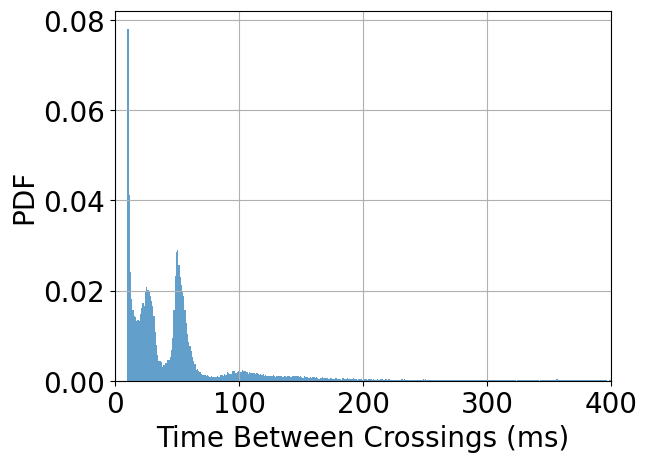

In [24]:
fig,ax=plt.subplots()
# bins=np.sort(df_traj_crossings['duration'].drop_duplicates())
bins=np.arange(10,401)

df_traj_crossings_fk['duration'].hist(bins=bins,ax=ax,color='C0',alpha=0.7,density=True)
# df_traj_crossings_lr['duration'].hist(bins=bins,ax=ax,color='C1',alpha=0.7,density=True)
ax.set_xlim([0,400])
format_plot(ax=ax,xlabel='Time Between Crossings (ms)',ylabel='PDF')
plt.show()

In [19]:
min_dur_crossings=10
print(f"df_traj_crossings lasting longer than {min_dur_crossings}:")
print(df_traj_crossings_fk['duration'].describe())

durmin=40
durmax=70
print(f"\ndf_traj_crossings_fk constrained from {durmin} to {durmax} ms:")
print(df_traj_crossings_fk[(df_traj_crossings_fk['duration']>=durmin)&(df_traj_crossings_fk['duration']<durmax)]['duration'].describe())

durmin=75
durmax=150
print(f"\ndf_traj_crossings_fk constrained from {durmin} to {durmax} ms:")
print(df_traj_crossings_fk[(df_traj_crossings_fk['duration']>=durmin)&(df_traj_crossings_fk['duration']<durmax)]['duration'].describe())

df_traj_crossings lasting longer than 10:
count    70973.000000
mean        60.050597
std         85.028587
min         10.000000
25%         20.000000
50%         41.000000
75%         56.000000
max       1672.000000
Name: duration, dtype: float64

df_traj_crossings_fk constrained from 40 to 70 ms:
count    23033.000000
mean        52.385838
std          5.678939
min         40.000000
25%         49.000000
50%         52.000000
75%         56.000000
max         69.000000
Name: duration, dtype: float64

df_traj_crossings_fk constrained from 75 to 150 ms:
count    7159.000000
mean      109.953485
std        19.443787
min        75.000000
25%        95.000000
50%       107.000000
75%       125.000000
max       149.000000
Name: duration, dtype: float64


# repeat for the Luo-Rudy model
- warning: long run time

In [58]:
###############
# lr
###############
log_folder_parquet=f'{data_folder}/from_wjr/positions_lr/200x200/tippos_per_001_log/'
assert os.path.exists(log_folder_parquet)
# max_trial_num=20
max_trial_num=640 #ert ~ 21 hours on 1 core
# max_trial_num=300 #ert ~ 20 minutes on all the cores i can get /10 hours on 1 core
trial_num=max_trial_num
df_log=load_parquet_by_trial_num(trial_num=trial_num,folder_parquet=log_folder_parquet)            
width = int(np.ceil(df_log['x'].max()))
height = int(np.ceil(df_log['y'].max()))
if printing:
    print(f"computational domain size:\n> {width=} px\n> {height=} px")

computational domain size:
> width=200 px
> height=200 px


In [174]:
#Warning: long run time
task_lst=[]
for trial_num in range(max_trial_num):
    task_lst.append((trial_num,str(log_folder_parquet),int(width),int(height),bool(use_final_annihilation),bool(use_reverse_time)))
if printing:
    print(f"added {len(task_lst)} tasks to task_lst!")
if testing:
    task=task_lst[0]
    rv = routine(task)
    assert type(rv)==type(tuple())
retval=eval_routine_daskbag(routine,task_lst,npartitions,printing=True)
###TODO: try evaluating with .compute().  does this fix the paralellization failing and defualting to serial?
# bag = db.from_sequence(task_lst, npartitions=npartitions).map(routine)
# start = time.time()
# retval = list(bag.compute())
# print(f"run time: {time.time()-start:.4f} (seconds)")
#parse data
# df_traj_lst=[]
df_traj_crossings_lst=[]
for rv in retval:
    if type('')==type(rv):
        if printing:
            print(rv)
    elif rv is not None:
        df_traj,df_traj_crossings = rv
        #df_traj_lst.append(df_traj)
        df_traj_crossings_lst.append(df_traj_crossings)
if printing:
    print(f"successfully computed msr data for N={len(df_traj_crossings_lst)} termination events.")
df_traj_crossings_lr = pd.concat(df_traj_crossings_lst)

#save as .csv
traj_crossings_lr_dir=f'{data_folder}/from_wjr/positions_lr/200x200/traj_crossings_num_terminations_{max_trial_num}.csv'
df_traj_crossings_lr.to_csv(traj_crossings_lr_dir)
beep(3)

added 640 tasks to task_lst!


Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x7f182d707310>
Traceback (most recent call last):
  File "/home/timothytyree/miniconda3/envs/pyenv_ub/lib/python3.9/site-packages/llvmlite/binding/executionengine.py", line 171, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):
KeyboardInterrupt: 


KeyboardInterrupt: 

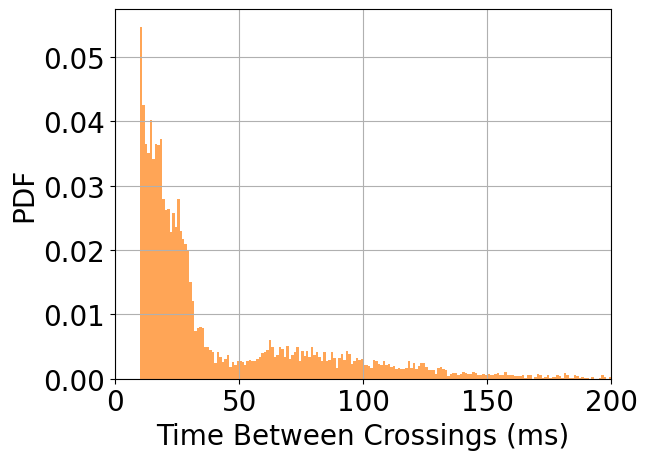

((7886, 10), (70973, 9))

In [60]:
fig,ax=plt.subplots()
# bins=np.sort(df_traj_crossings['duration'].drop_duplicates())
bins=np.arange(10,201)

# df_traj_crossings_fk['duration'].hist(bins=bins,ax=ax,color='C0',alpha=0.7,density=True)
df_traj_crossings_lr['duration'].hist(bins=bins,ax=ax,color='C1',alpha=0.7,density=True)
ax.set_xlim([0,200])
format_plot(ax=ax,xlabel='Time Between Crossings (ms)',ylabel='PDF')
plt.show()
df_traj_crossings_lr.shape,df_traj_crossings_fk.shape

In [55]:
70973/274

259.0255474452555

In [61]:
# min_dur_crossings=10
print(f"df_traj_crossings lasting longer than {min_dur_crossings}:")
print(df_traj_crossings_lr['duration'].describe())

durmin=40
durmax=70
print(f"\ndf_traj_crossings_lr constrained from {durmin} to {durmax} ms:")
print(df_traj_crossings_lr[(df_traj_crossings_lr['duration']>=durmin)&(df_traj_crossings_lr['duration']<durmax)]['duration'].describe())

durmin=75
durmax=150
print(f"\ndf_traj_crossings_lr constrained from {durmin} to {durmax} ms:")
print(df_traj_crossings_lr[(df_traj_crossings_lr['duration']>=durmin)&(df_traj_crossings_lr['duration']<durmax)]['duration'].describe())

df_traj_crossings lasting longer than 10:
count    7886.000000
mean       42.396652
std        41.651992
min        10.000000
25%        16.000000
50%        24.000000
75%        60.000000
max       366.000000
Name: duration, dtype: float64

df_traj_crossings_lr constrained from 40 to 70 ms:
count    806.000000
mean      56.065757
std        8.873263
min       40.000000
25%       48.000000
50%       58.000000
75%       63.000000
max       69.000000
Name: duration, dtype: float64

df_traj_crossings_lr constrained from 75 to 150 ms:
count    1274.000000
mean      101.864992
std        19.525454
min        75.000000
25%        85.000000
50%        98.000000
75%       117.000000
max       149.000000
Name: duration, dtype: float64


# analysis of the max time between crossings

In [103]:
df = df_traj_crossings_lr
df.head()

,tstart,tend,xs_unwrap,ys_unwrap,start_index,end_index,duration,index_self,index_other,trial_num
0,244.0,310.0,2.268217,-4.675969,1.0,67.0,66.0,-9999,0,0
0,247.0,301.0,1.762500,6.937500,4.0,58.0,54.0,2,-9999,0
2,272.0,297.0,-1.100000,4.500000,29.0,54.0,25.0,2,-9999,0
3,273.0,296.0,-1.853333,3.653333,30.0,53.0,23.0,2,-9999,0
0,42.0,121.0,10.247191,1.107865,2.0,81.0,79.0,3,-9999,0


In [104]:
#TODO: imbue df_traj_crossings_fk with 'trialnum'
trial_num_lst=[]
last_index=0
trial_num=0
for n,row in df_traj_crossings_fk.iterrows():
    max_index=np.max((row['index_self'],row['index_other']))
    if max_index<last_index:
        trial_num+=1
    last_index=max_index
    trial_num_lst.append(trial_num)
df_traj_crossings_fk['trial_num']=trial_num_lst
np.unique(trial_num_lst)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [105]:
maxdur_lst=[]
for n,g in df_traj_crossings_lr.groupby(by=['trial_num','index_self','index_other']):
    maxdur_lst.append(g['duration'].max())
maxdur_values_lr = np.array(maxdur_lst)

maxdur_lst=[]
for n,g in df_traj_crossings_fk.groupby(by=['trial_num','index_self','index_other']):
    maxdur_lst.append(g['duration'].max())
maxdur_values_fk = np.array(maxdur_lst)

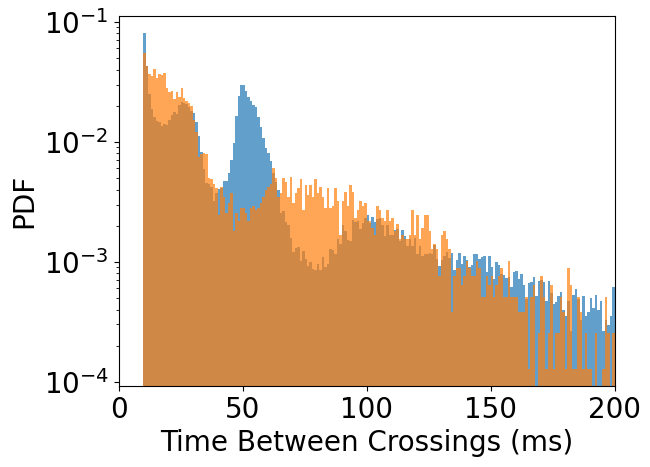

In [106]:
fig,ax=plt.subplots()
# bins=np.sort(df_traj_crossings['duration'].drop_duplicates())
bins=np.arange(10,201)
df_traj_crossings_fk['duration'].hist(bins=bins,ax=ax,color='C0',alpha=0.7,density=True)
df_traj_crossings_lr['duration'].hist(bins=bins,ax=ax,color='C1',alpha=0.7,density=True)
ax.set_xlim([0,200])
format_plot(ax=ax,xlabel='Time Between Crossings (ms)',ylabel='PDF')
ax.grid(False)
plt.yscale('log')
plt.show()
# df_traj_crossings_lr.shape,df_traj_crossings_fk.shape

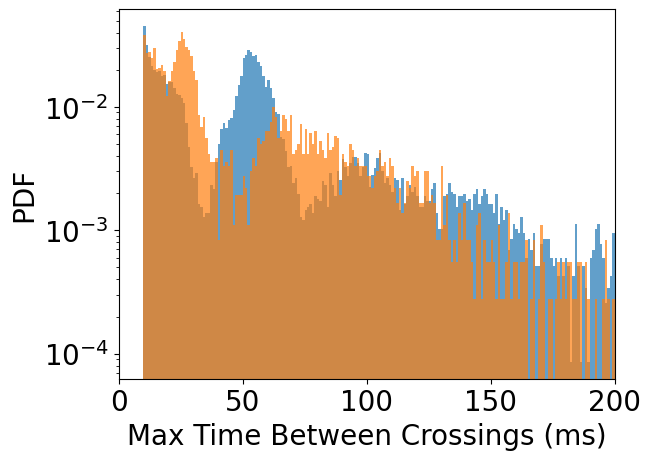

In [107]:
fig,ax=plt.subplots()
bins=np.arange(10,201)
ax.hist(maxdur_values_fk,bins=bins,color='C0',alpha=0.7,density=True)
ax.hist(maxdur_values_lr,bins=bins,color='C1',alpha=0.7,density=True)
ax.set_yscale('log')
ax.grid(False)
ax.set_xlim([0,200])
format_plot(ax=ax,xlabel='Max Time Between Crossings (ms)',ylabel='PDF')
plt.show()
# df_traj_crossings_lr.shape,df_traj_crossings_fk.shape

In [102]:
print(f"Max Time Between Crossings (FK):")
print(pd.Series(maxdur_values_fk).describe())

print(f"\nMax Time Between Crossings (LR):")
print(pd.Series(maxdur_values_lr).describe())

Max Time Between Crossings (FK):
count    12368.000000
mean        72.990298
std         93.879459
min         10.000000
25%         21.000000
50%         52.000000
75%         78.000000
max       1672.000000
dtype: float64

Max Time Between Crossings (LR):
count    3644.000000
mean       49.254940
std        42.965077
min        10.000000
25%        20.000000
50%        29.000000
75%        72.000000
max       366.000000
dtype: float64


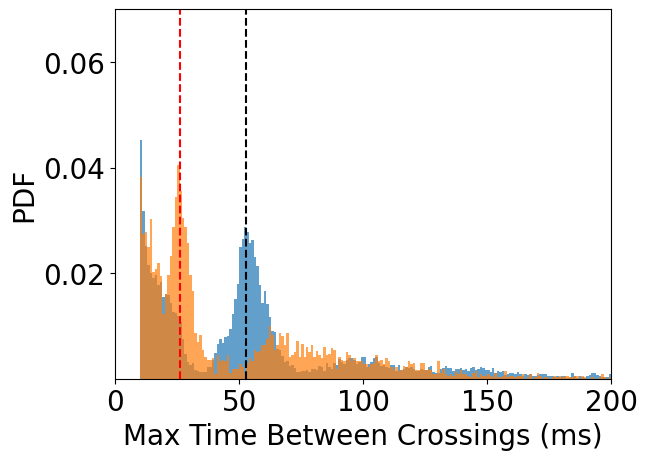

peak_dur_fk=53 ms, peak_dur_lr=26 ms


In [122]:
fig,ax=plt.subplots()
bins=np.arange(10,201)
ax.hist(maxdur_values_fk,bins=bins,color='C0',alpha=0.7,density=True)
ax.hist(maxdur_values_lr,bins=bins,color='C1',alpha=0.7,density=True)

#plot vertical lines at the peaks
peak_dur_lr=26
peak_dur_fk=53
yv=np.logspace(-5,-1,10)
ax.plot(peak_dur_lr+0.*yv,yv,'r--')
ax.plot(peak_dur_fk+0.*yv,yv,'k--')


#format_plot
# ax.set_yscale('log')
ax.grid(False)
ax.set_xlim([0,200])
ax.set_ylim([1e-5,7e-2])
format_plot(ax=ax,xlabel='Max Time Between Crossings (ms)',ylabel='PDF')
plt.show()
# df_traj_crossings_lr.shape,df_traj_crossings_fk.shape
print(f"{peak_dur_fk=} ms, {peak_dur_lr=} ms")

In [123]:
period_fk = 115.94 #ms
period_lr = 97.36  #ms


In [127]:
print(f"{period_fk/peak_dur_fk=:.4f}")
print(f"{period_lr/peak_dur_lr=:.4f}")

period_fk/peak_dur_fk=2.1875
period_lr/peak_dur_lr=3.7446


In [135]:
np.random.seed(42)
#bootstrap mean and 95% CI
values = df_traj_crossings_fk['duration'].values
Delta_mean,p=bootstrap_95CI_Delta_mean(values,num_samples=1000)
mean  = np.mean(values)
print(f"Fenton-Karma:\nmean time between crossings: {mean:.4f} +/- {Delta_mean:.4f}\n(N_crossings={values.shape[0]}, p_normal={p:.6f})")

#bootstrap mean and 95% CI
values = df_traj_crossings_lr['duration'].values
Delta_mean,p=bootstrap_95CI_Delta_mean(values,num_samples=1000)
mean  = np.mean(values)
print(f"\nLuo-Rudy:\nmean time between crossings: {mean:.4f} +/- {Delta_mean:.4f}\n(N_crossings={values.shape[0]}, p_normal={p:.6f})")

Fenton-Karma:
mean time between crossings: 60.0506 +/- 0.6222
(N_crossings=70973, p_normal=0.258362)

Luo-Rudy:
mean time between crossings: 42.3967 +/- 0.9170
(N_crossings=7886, p_normal=0.884430)


In [142]:
np.random.seed(42)
mindur=50 #ms
#bootstrap mean and 95% CI
values = df_traj_crossings_fk['duration'].values
values =values[values>mindur]
Delta_mean,p=bootstrap_95CI_Delta_mean(values,num_samples=1000)
mean  = np.mean(values)
print(f"Fenton-Karma:\nmean time between crossings: {mean:.4f} +/- {Delta_mean:.4f}\n(N_crossings={values.shape[0]}, p_normal={p:.6f})")

#bootstrap mean and 95% CI
values = df_traj_crossings_lr['duration'].values
values =values[values>mindur]
Delta_mean,p=bootstrap_95CI_Delta_mean(values,num_samples=1000)
mean  = np.mean(values)
print(f"\nLuo-Rudy:\nmean time between crossings: {mean:.4f} +/- {Delta_mean:.4f}\n(N_crossings={values.shape[0]}, p_normal={p:.6f})")

Fenton-Karma:
mean time between crossings: 117.8710 +/- 1.4167
(N_crossings=26382, p_normal=0.959126)

Luo-Rudy:
mean time between crossings: 98.4314 +/- 1.7810
(N_crossings=2193, p_normal=0.269472)


# compute the number of loops per particle
- then, estimate period as number of loops / mean lifetime

In [157]:
count_lst=[]
for n,g in df_traj_crossings_lr.groupby(by=['trial_num','index_self','index_other']):
    count_lst.append(g['duration'].count())
num_loops_values_lr = np.array(count_lst)

maxdur_lst=[]
for n,g in df_traj_crossings_fk.groupby(by=['trial_num','index_self','index_other']):
    count_lst.append(g['duration'].count())
num_loops_values_fk = np.array(count_lst)


print(f"Mean Number of Loops Per Annihilating Particle (FK):")
print(pd.Series(num_loops_values_lr).describe())

print(f"Mean Number of Loops Per Annihilating Particle (LR):")
print(pd.Series(num_loops_values_fk).describe())

Mean Number of Loops Per Annihilating Particle (FK):
count    3644.000000
mean        2.164105
std         1.803393
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        18.000000
dtype: float64
Mean Number of Loops Per Annihilating Particle (LR):
count    16012.000000
mean         4.924994
std          7.862422
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        138.000000
dtype: float64


In [201]:
#recall how many particles were considered and scale accordingly
range_dir="/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl"
data_lst = load_from_pickle(range_dir)
trial_num_lst=[]
annihilation_count_lst=[]
for data in data_lst:
    trial_num_lst.append(np.max(data['trial_num']))
    annihilation_count_lst.append(np.max(data['annihilation_index']))
df_count_fk = pd.DataFrame(dict(trial_num=trial_num_lst,annihilation_count=annihilation_count_lst))
num_particles_total = int(2*df_count_fk[df_count_fk['trial_num']<20].sum().values[1])
print(num_particles_total) #22694
#expected: 11293*0.9082 = 10256.3026 particles

22694


12368


In [184]:
#recall how many particles were considered and scale accordingly
range_dir="/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl"
data_lst = load_from_pickle(range_dir)
trial_num_lst=[]
annihilation_count_lst=[]
for data in data_lst:
    trial_num_lst.append(np.max(data['trial_num']))
    annihilation_count_lst.append(np.max(data['annihilation_index']))
df_count_lr = pd.DataFrame(dict(trial_num=trial_num_lst,annihilation_count=annihilation_count_lst))

In [207]:
#count the number of particles that loop at least 1 time
count_particles=0
for n,g in df_traj_crossings_fk.groupby(by=['trial_num','index_self','index_other']):
    count_particles+=1
num_particles_looping_fk = count_particles

#count the number of particles that loop at least 1 time
count_particles=0
for n,g in df_traj_crossings_lr.groupby(by=['trial_num','index_self','index_other']):
    count_particles+=1
num_particles_looping_lr = count_particles
num_particles_looping_fk,num_particles_looping_lr

(12368, 3644)

In [222]:
df_count_fk[df_count_fk['trial_num']<20].sum().values[1]
number_termination_events_considered_fk = df_traj_crossings_fk['trial_num'].max()+1
number_termination_events_considered_lr = df_traj_crossings_lr['trial_num'].max()+1
number_termination_events_considered_fk,number_termination_events_considered_lr

(20, 639)

In [214]:
lifetime_fk= 105.3 # (1.6) ms
lifetime_lr= 33.37 # (73) ms

period_fk = 115.94 #ms
period_lr = 97.36  #ms
print(f"Expected num. revolutions per lifetime: {lifetime_fk/period_fk=:.4f}")
print(f"Expected num. revolutions per lifetime: {lifetime_lr/period_lr=:.4f}")

Expected num. revolutions per lifetime: lifetime_fk/period_fk=0.9082
Expected num. revolutions per lifetime: lifetime_lr/period_lr=0.3427


In [226]:
s_num_annihilations = df_traj_crossings_fk.groupby(by='trial_num')['index_self'].max()
num_loops_fk = s_num_annihilations[s_num_annihilations>-1]
num_loops_total = num_loops_fk.sum()
num_particles_total = int(2*df_count_fk[df_count_fk['trial_num']<20].sum().values[1])
print(f"Fenton-Karma:")
print(f"number_termination_events_considered: {number_termination_events_considered_fk}")
print(f"total number of loops observed longer than 10ms: {num_loops_total}")
print(f"(number of particles considered: {num_particles_total})")
print(f"(mean number of loops per particle lifetime: {num_loops_total/num_particles_total:.4f})")
print(f"number of particles considered with at least 1 loop: {num_particles_looping_fk}")
print(f"mean number of loops per particle lifetime (at least 1 loop): {num_loops_total/num_particles_looping_fk:.4f}")
print(f"expected num. revolutions per lifetime: {lifetime_fk/period_fk=:.4f}")

s_num_annihilations = df_traj_crossings_lr.groupby(by='trial_num')['index_self'].max()
num_loops_lr = s_num_annihilations[s_num_annihilations>-1]
num_loops_total = num_loops_lr.sum()
#num_particles_total = int(2*df_count_lr[df_count_lr['trial_num']<20].sum().values[1])
num_particles_total = int(2*df_count_lr.sum().values[1])
print(f"\nLuo-Rudy:")
print(f"number_termination_events_considered: {number_termination_events_considered_lr}")
print(f"total number of loops observed longer than 10ms: {num_loops_total}")
print(f"(number of particles considered with at least 1 loop: {num_particles_looping_lr})")
print(f"(mean number of loops per particle lifetime (at least 1 loop): {num_loops_total/num_particles_looping_lr:.4f})")
print(f"number of particles considered: {num_particles_total}")
print(f"mean number of loops per particle lifetime: {num_loops_total/num_particles_total:.4f}")
print(f"expected num. revolutions per lifetime: {lifetime_lr/period_lr=:.4f}")


Fenton-Karma:
number_termination_events_considered: 20
total number of loops observed longer than 10ms: 11293
(number of particles considered: 22694)
(mean number of loops per particle lifetime: 0.4976)
number of particles considered with at least 1 loop: 12368
mean number of loops per particle lifetime (at least 1 loop): 0.9131
expected num. revolutions per lifetime: lifetime_fk/period_fk=0.9082

Luo-Rudy:
number_termination_events_considered: 639
total number of loops observed longer than 10ms: 10108
(number of particles considered with at least 1 loop: 3644)
(mean number of loops per particle lifetime (at least 1 loop): 2.7739)
number of particles considered: 29402
mean number of loops per particle lifetime: 0.3438
expected num. revolutions per lifetime: lifetime_lr/period_lr=0.3427


# estimating period from kinematic period

$$
\hat{T}(t)=\frac{2\pi ||\vec{r}'(t)||^2}{||\vec{r}'(t)\times\vec{r}''(t)||}
$$

where the velocity and acceleration of the observed trajectory $\vec{r}(t)$ is computed using a Savitzky-Golay filtration.

In [2]:
DS=5/200 #cm per pixel
tavg2=14 #ms
DT=1. #ms
width=200. #px
height=200. #px
min_minlifetime=40. #ms
navg2=int(tavg2/DT)
if not (navg2%2==1): #odd navg2 is required by savgol_filter
    navg2+=1
    tavg2=np.around(navg2*DT,7)
navg2

NameError: name 'np' is not defined

In [3]:
#compute the xy values
savgol_kwargs0=dict(window_length=navg2,polyorder=3,
    deriv=0,delta=1.0,axis=-1,mode='interp')
#compute the xy velocities
savgol_kwargs1=dict(window_length=navg2,polyorder=3,
    deriv=1,delta=1.0,axis=-1,mode='interp')
#compute the xy accelerations
savgol_kwargs2=dict(window_length=navg2,polyorder=3,
    deriv=2,delta=1.0,axis=-1,mode='interp')

In [17]:
#estimated run time ~ 20 minutes for 20 trials
#recall how many particles were considered and scale accordingly
range_dir="/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl"
# range_dir="/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl"
data_lst_all = load_from_pickle(range_dir)
max_num_trials=20
data_lst=[]
for i in range(max_num_trials):
    data_lst.append(data_lst_all[i])
# # Initial call to print 0% progress
num_steps=len(data_lst)
printProgressBar(0, num_steps, prefix = 'Progress:', suffix = 'Complete', length = 50)
trial_num_lst=[]
annihilation_count_lst=[]
traj_lst=[]
for step,data in enumerate(data_lst):
    trial_num=np.max(data['trial_num'])
    trial_num_lst.append(trial_num)
    annihilation_count_lst.append(np.max(data['annihilation_index']))

    d = pd.DataFrame(data)#.sort_values(by='t')
    #extract trajectories of particle self
    for annihilation_index,g in d.groupby('annihilation_index'):
        gg = g.sort_values('tdeath')
        t_values=gg['tdeath']
        x_values,y_values = unwrap_and_center_xy_values(gg['x'].values,gg['y'].values,width,height)#,**kwargs)
        minlifetime=np.max(t_values)
        if minlifetime>=min_minlifetime:
            dict_traj=dict(trial_num=trial_num,
                           particle=annihilation_index,
                           t=t_values,
                           x=x_values,
                           y=y_values)
            #compute smoothed derivatives
            dd = pd.DataFrame(dict_traj)
            dd['vx'] = savgol_filter(dd['x'],**savgol_kwargs1)*DS/DT #cm per ms
            dd['vy'] = savgol_filter(dd['y'],**savgol_kwargs1)*DS/DT #cm per ms
            dd['ax'] = savgol_filter(dd['x'],**savgol_kwargs2)*DS/(DT**2) #cm per ms^2
            dd['ay'] = savgol_filter(dd['y'],**savgol_kwargs2)*DS/(DT**2) #cm per ms^2
            #compute instantaneous period
            dd['T']=2*np.pi*(dd['vx']**2+dd['vy']**2)/np.abs(dd['vx']*dd['ay'] - dd['vy']*dd['ax'])
            dd['sq_vel']=dd['vx']**2+dd['vy']**2
            T_values=dd['T'].values        
            #record
            traj_lst.append(dd[['trial_num','particle','t','T','sq_vel']].copy())
    printProgressBar(step + 1, num_steps, prefix = 'Progress:', suffix = 'Complete', length = 50)
df_inst_period_fk = pd.concat(traj_lst)
df_count_fk = pd.DataFrame(dict(trial_num=trial_num_lst,annihilation_count=annihilation_count_lst))
#save df_inst_period_fk,lr as .csv
inst_period_fk_dir="/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_inst_period_timeseries.csv"
df_inst_period_fk.to_csv(inst_period_fk_dir,index=False)

In [21]:
#estimated run time ~ 20 minutes for all available trials
#recall how many particles were considered and scale accordingly
# range_dir="/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl"
range_dir="/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl"
data_lst = load_from_pickle(range_dir)
# # Initial call to print 0% progress
num_steps=len(data_lst)
printProgressBar(0, num_steps, prefix = 'Progress:', suffix = 'Complete', length = 50)
trial_num_lst=[]
annihilation_count_lst=[]
traj_lst=[]
for step,data in enumerate(data_lst):
    trial_num=np.max(data['trial_num'])
    trial_num_lst.append(trial_num)
    annihilation_count_lst.append(np.max(data['annihilation_index']))
    d = pd.DataFrame(data)#.sort_values(by='t')
    #extract trajectories of particle self
    for annihilation_index,g in d.groupby('annihilation_index'):
        gg = g.sort_values('tdeath')
        t_values=gg['tdeath']
        x_values,y_values = unwrap_and_center_xy_values(gg['x'].values,gg['y'].values,width,height)#,**kwargs)
        minlifetime=np.max(t_values)
        if minlifetime>=min_minlifetime:
            dict_traj=dict(trial_num=trial_num,
                           particle=annihilation_index,
                           t=t_values,
                           x=x_values,
                           y=y_values)
            #compute smoothed derivatives
            dd = pd.DataFrame(dict_traj)
            dd['vx'] = savgol_filter(dd['x'],**savgol_kwargs1)/DT #pixels per ms
            dd['vy'] = savgol_filter(dd['y'],**savgol_kwargs1)/DT #pixels per ms
            dd['ax'] = savgol_filter(dd['x'],**savgol_kwargs2)/(DT**2) #pixels per ms^2
            dd['ay'] = savgol_filter(dd['y'],**savgol_kwargs2)/(DT**2) #pixels per ms^2
            #compute instantaneous period
            dd['T']=2*np.pi*(dd['vx']**2+dd['vy']**2)/np.abs(dd['vx']*dd['ay'] - dd['vy']*dd['ax'])
            dd['sq_vel']=dd['vx']**2+dd['vy']**2
            T_values=dd['T'].values        
            #record
            traj_lst.append(dd[['trial_num','particle','t','T','sq_vel']].copy())
    printProgressBar(step + 1, num_steps, prefix = 'Progress:', suffix = 'Complete', length = 50)
df_inst_period_lr = pd.concat(traj_lst)
df_count_lr = pd.DataFrame(dict(trial_num=trial_num_lst,annihilation_count=annihilation_count_lst))
inst_period_lr_dir="/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_inst_period_timeseries.csv"
df_inst_period_lr.to_csv(inst_period_lr_dir,index=False)
print(df_inst_period_lr.shape)

(382747, 5)██████████████████████████████████████████████████| 100.0% Complete


In [22]:
beep(4)



0

In [1]:
1+1

2

In [23]:
assert os.path.exists(inst_period_fk_dir)
df_inst_period_fk.shape,df_inst_period_lr.shape

((1102476, 5), (382747, 5))

In [24]:
df_inst_period_fk.head()

,trial_num,particle,t,T,sq_vel
253460,0,0,0.0,72.141638,4.558163
253458,0,0,1.0,71.669780,3.776704
253456,0,0,2.0,73.313606,3.147932
253454,0,0,3.0,77.665188,2.633589
253452,0,0,4.0,85.986844,2.202186


<function lib.viewer.bluf.pdf_utils.format_plot(ax, xlabel, ylabel, fontsize=20, use_loglog=False, **kwargs)>

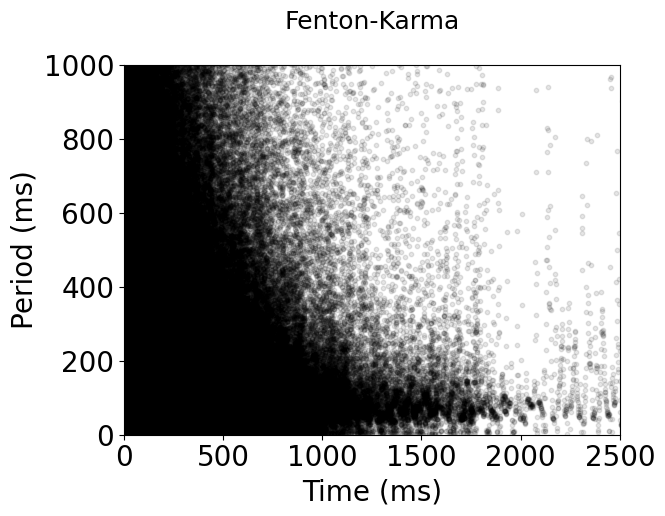

In [39]:
#TODO: visualize df_inst_period_fk,lr 
fig,ax=plt.subplots()
# df_inst_period_fk.plot.scatter(ax=ax,x='t',y='T',c='trial_num',cmap='Paired',s=10)
df_inst_period_fk.plot.scatter(ax=ax,x='t',y='T',c='black',s=10,alpha=0.1)
format_plot(ax=ax,xlabel='Time (ms)',ylabel='Period (ms)')
ax.set_xlim([0,2500])
ax.set_ylim([0,1000])
ax.set_title("Fenton-Karma\n",fontsize=18)
plt.show()

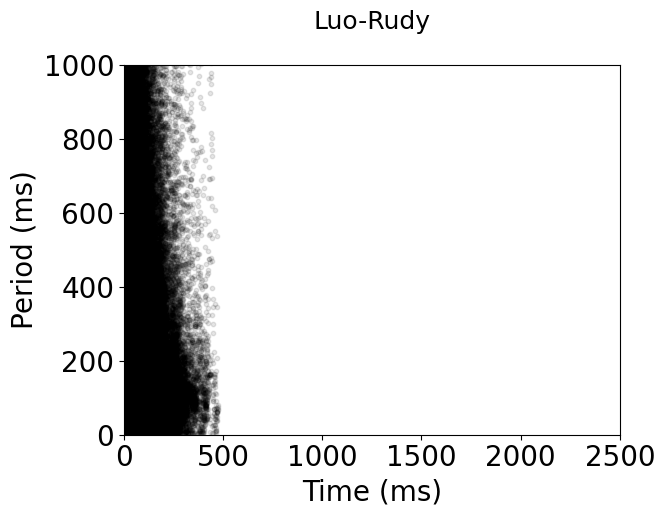

In [40]:
#TODO: visualize df_inst_period_fk,lr 
fig,ax=plt.subplots()
# df_inst_period_lr.plot.scatter(ax=ax,x='t',y='T',c='trial_num',cmap='Paired',s=10)
df_inst_period_lr.plot.scatter(ax=ax,x='t',y='T',c='black',s=10,alpha=0.1)
format_plot(ax=ax,xlabel='Time (ms)',ylabel='Period (ms)')
ax.set_xlim([0,2500])
ax.set_ylim([0,1000])
ax.set_title("Luo-Rudy\n",fontsize=18)
plt.show()

In [105]:
#temporal averaging for each particle
dict_median_lst=[]
for n,g in df_inst_period_lr.groupby(by=['trial_num','particle']):
    dict_median_lst.append(dict(g.median()))
#     dict_median_lst.append(dict(g.mean()))
df_median_lr = pd.DataFrame(dict_median_lst)

#temporal averaging for each particle
dict_median_lst=[]
for n,g in df_inst_period_fk.groupby(by=['trial_num','particle']):
    dict_median_lst.append(dict(g.median()))
#     dict_median_lst.append(dict(g.mean()))
df_median_fk = pd.DataFrame(dict_median_lst)
df_median_fk.shape,df_median_lr.shape

((6491, 5), (4222, 5))

In [106]:
# dict_median_lst[0]

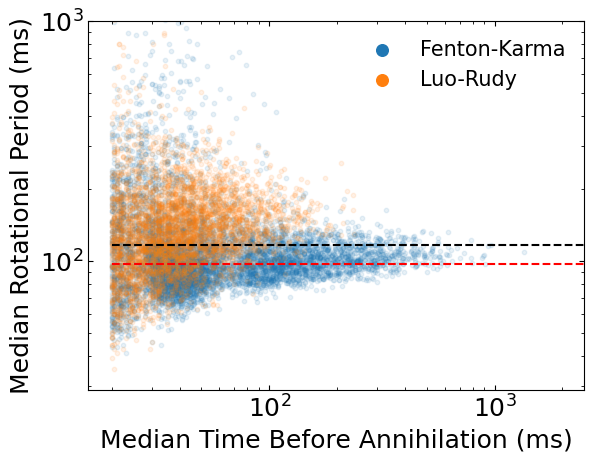

In [107]:
ontsize=18
fig,ax=plt.subplots()
df_median_fk.plot.scatter(ax=ax,x='t',y='T',c='C0',s=10,alpha=0.1,label='Fenton-Karma')
df_median_lr.plot.scatter(ax=ax,x='t',y='T',c='C1',s=10,alpha=0.1,label='Luo-Rudy')
format_plot(ax=ax,xlabel='Median Time Before Annihilation (ms)',ylabel='Median Rotational Period (ms)',fontsize=fontsize,use_loglog=True)

# #plot horizontal lines at the peaks
peak_period_lr=97.36 #ms
peak_period_fk=115.94 #ms
# yv=np.logspace(1,3,10)
yv=np.linspace(20,2500,10)
ax.plot(yv,peak_period_lr+0.*yv,'r--')
ax.plot(yv,peak_period_fk+0.*yv,'k--')


# format_plot
ax.tick_params(top=True, right=True,direction='in',which='both')
# format_plot(ax=ax,xlabel=r'q (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize,use_loglog=True)
# ax.legend(loc='upper left',fontsize=fontsize-2)
# ax.legend(loc='lower right',fontsize=fontsize-2.,frameon=False,ncol=2)
# leg = ax.legend(loc=(1.04,0.2),fontsize=fontsize-2.,frameon=False)
leg = ax.legend(loc='upper right',fontsize=fontsize-3.,frameon=False,ncol=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([70])
ax.set_xlim([0,2500])
ax.set_ylim([0,1000])
# ax.set_title("Fenton-Karma\n",fontsize=18)
# ax.set_title("Luo-Rudy\n",fontsize=18)
plt.show()

median median rotational periods: 99.6758 ms (FK)
period from simulated annealing: 115.94 ms (FK)

median median rotational periods: 130.9342 ms (LR)
period from simulated annealing: 97.36 ms (LR)


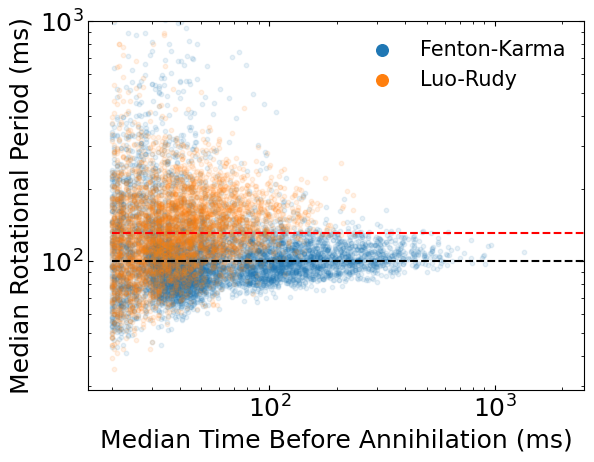

In [98]:
peak_period_lr=97.36 #ms 
peak_period_fk=115.94 #ms
Tavg_fk = df_median_fk['T'].median()
Tavg_lr = df_median_lr['T'].median()

print(f"median median rotational periods: {Tavg_fk:.4f} ms (FK)")
print(f"period from simulated annealing: {peak_period_fk} ms (FK)")
print(f"")
print(f"median median rotational periods: {Tavg_lr:.4f} ms (LR)")
print(f"period from simulated annealing: {peak_period_lr} ms (LR)")

ontsize=18
fig,ax=plt.subplots()
df_median_fk.plot.scatter(ax=ax,x='t',y='T',c='C0',s=10,alpha=0.1,label='Fenton-Karma')
df_median_lr.plot.scatter(ax=ax,x='t',y='T',c='C1',s=10,alpha=0.1,label='Luo-Rudy')
format_plot(ax=ax,xlabel='Median Time Before Annihilation (ms)',ylabel='Median Rotational Period (ms)',fontsize=fontsize,use_loglog=True)

# #plot horizontal lines at the peaks
peak_period_lr=Tavg_lr#df_median_lr['T'].mean() # 97.36 #ms
peak_period_fk=Tavg_fk#df_median_fk['T'].mean() # 115.94 #ms
# yv=np.logspace(1,3,10)
yv=np.linspace(20,2500,10)
ax.plot(yv,peak_period_lr+0.*yv,'r--')
ax.plot(yv,peak_period_fk+0.*yv,'k--')


# format_plot
ax.tick_params(top=True, right=True,direction='in',which='both')
# format_plot(ax=ax,xlabel=r'q (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize,use_loglog=True)
# ax.legend(loc='upper left',fontsize=fontsize-2)
# ax.legend(loc='lower right',fontsize=fontsize-2.,frameon=False,ncol=2)
# leg = ax.legend(loc=(1.04,0.2),fontsize=fontsize-2.,frameon=False)
leg = ax.legend(loc='upper right',fontsize=fontsize-3.,frameon=False,ncol=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([70])
ax.set_xlim([0,2500])
ax.set_ylim([0,1000])
# ax.set_title("Fenton-Karma\n",fontsize=18)
# ax.set_title("Luo-Rudy\n",fontsize=18)
plt.show()

In [95]:
peak_period_lr=97.36 #ms 
peak_period_fk=115.94 #ms
Tavg_fk = df_median_fk['T'].mean()
Tavg_lr = df_median_lr['T'].mean()
# Tavg_fk = np.sqrt((df_median_fk['T']**2).mean())
# Tavg_lr = np.sqrt((df_median_lr['T']**2).mean())
print(f"mean median rotational periods: {Tavg_fk:.4f} ms (FK)")
print(f"period from simulated annealing: {peak_period_fk} ms (FK)")
print(f"")
print(f",ean median rotational periods: {Tavg_lr:.4f} ms (LR)")
print(f"period from simulated annealing: {peak_period_lr} ms (LR)")

mean median rotational periods: 118.9916 ms (FK)
period from simulated annealing: 115.94 ms (FK)

,ean median rotational periods: 143.9403 ms (LR)
period from simulated annealing: 97.36 ms (LR)


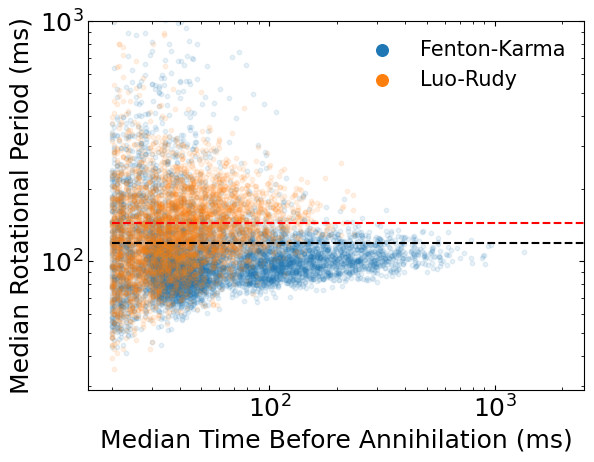

In [97]:
ontsize=18
fig,ax=plt.subplots()
df_median_fk.plot.scatter(ax=ax,x='t',y='T',c='C0',s=10,alpha=0.1,label='Fenton-Karma')
df_median_lr.plot.scatter(ax=ax,x='t',y='T',c='C1',s=10,alpha=0.1,label='Luo-Rudy')
format_plot(ax=ax,xlabel='Median Time Before Annihilation (ms)',ylabel='Median Rotational Period (ms)',fontsize=fontsize,use_loglog=True)

# #plot horizontal lines at the peaks
peak_period_lr=Tavg_lr#df_median_lr['T'].mean() # 97.36 #ms
peak_period_fk=Tavg_fk#df_median_fk['T'].mean() # 115.94 #ms
# yv=np.logspace(1,3,10)
yv=np.linspace(20,2500,10)
ax.plot(yv,peak_period_lr+0.*yv,'r--')
ax.plot(yv,peak_period_fk+0.*yv,'k--')


# format_plot
ax.tick_params(top=True, right=True,direction='in',which='both')
# format_plot(ax=ax,xlabel=r'q (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize,use_loglog=True)
# ax.legend(loc='upper left',fontsize=fontsize-2)
# ax.legend(loc='lower right',fontsize=fontsize-2.,frameon=False,ncol=2)
# leg = ax.legend(loc=(1.04,0.2),fontsize=fontsize-2.,frameon=False)
leg = ax.legend(loc='upper right',fontsize=fontsize-3.,frameon=False,ncol=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([70])
ax.set_xlim([0,2500])
ax.set_ylim([0,1000])
# ax.set_title("Fenton-Karma\n",fontsize=18)
# ax.set_title("Luo-Rudy\n",fontsize=18)
plt.show()

In [94]:
tmin=25
tmax=1000
# tmin=100
# tmax=300
peak_period_lr=97.36 #ms 
peak_period_fk=115.94 #ms
Tavg_fk = df_median_fk[(df_median_fk['t']>=tmin)&(df_median_fk['t']<tmax)]['T'].mean()
Tavg_lr = df_median_lr[(df_median_lr['t']>=tmin)&(df_median_lr['t']<tmax)]['T'].mean()
# Tavg_fk = np.sqrt((df_median_fk['T']**2).mean())
# Tavg_lr = np.sqrt((df_median_lr['T']**2).mean())
print(f"mean median rotational periods: {Tavg_fk:.4f} ms (FK)")
print(f"period from simulated annealing: {peak_period_fk} ms (FK)")
print(f"")
print(f"mean median rotational periods: {Tavg_lr:.4f} ms (LR)")
print(f"period from simulated annealing: {peak_period_lr} ms (LR)")

mean median rotational periods: 117.0490 ms (FK)
period from simulated annealing: 115.94 ms (FK)

,ean median rotational periods: 144.3268 ms (LR)
period from simulated annealing: 97.36 ms (LR)


# TODO: estimate rms velocity of spiral tips

In [31]:
inst_period_fk_dir="/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_inst_period_timeseries.csv"
inst_period_lr_dir="/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_inst_period_timeseries.csv"
# # inst_period_fk_dir=f"/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_inst_period_timeseries.csv"
# # inst_period_lr_dir="/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_inst_period_timeseries.csv"

In [33]:
df_inst=pd.read_csv(inst_period_fk_dir)
# df_inst=pd.read_csv(inst_period_lr_dir)
df_inst.head()

df = df_inst
v_values = df['sq_vel'].values
mean,Delta_mean,num_obs,p_normal=comp_mean_bootstrap_uncertainty(v_values)
if printing:
    print(f" - all positions together (use this one?): mean squared velocity: {mean:.4f} +/- {Delta_mean:.4f} ms (N={num_obs}, p_normal: {p_normal:.4f})")#" from {num_termination_events} termination events")

vsq_values = df.groupby(['trial_num','particle'])['sq_vel'].mean().values
v_rms =np.sqrt(np.mean(vsq_values))

meanx,Delta_meanx,num_obs,p_normal=comp_mean_bootstrap_uncertainty(vsq_values)
printing=True
if printing:
    print(f"mean squared velocity: {meanx:.4f} +/- {Delta_meanx:.4f} cm/s (N={num_obs}, {p_normal=:.4f})")
    print(f"rms velocity: {np.sqrt(meanx):.4f} +/- {0.5*Delta_meanx/np.sqrt(meanx):.4f} cm/s (N={num_obs}, {p_normal=:.4f})")

 - all positions together (use this one?): mean squared velocity: 0.3620 +/- 0.0028 ms (N=1102476, p_normal: 0.0922)
mean squared velocity: 0.4237 +/- 0.0089 cm/s (N=6491, p_normal=0.2487)
rms velocity: 0.6509 +/- 0.0068 cm/s (N=6491, p_normal=0.2487)


FK --> rms velocity: 
LR --> rms velocity: 1.3507 +/- 0.0135 cm/s (N=4222, p_normal=0.0405)


In [36]:
#uncertainty estimates mean particle number for the full models
# 2.384248/np.sqrt(641)*1.96
3.171279/np.sqrt(81)*1.96

0.6906340933333334

In [34]:
bootstrap_95CI_Delta_mean(vsq_values, num_samples=1000)

(0.009125882632636629, 0.3525960019897339)

In [23]:
bootstrap_95CI_Delta_mean

<function lib.measure.bootstrap.bootstrap_95CI_Delta_mean(x, num_samples=1000)>

# scratchwerk

In [415]:
# print("estimated run time per call: ~ 7 minutes")
# #tracking task
# #task for estimating spiral period
# def routine_track_self_crossings(df_log,width,height,use_final_annihilation):
#     df_traj=track_particle_annihilations_pbc_nearest_neighbors_simple(df_log,
#                             width=int(width),height=int(height),
#                             DS=0.025,
#                             max_disp=30, #15-1000 appears to work
#                             max_dist=20, # 20 appears to work
#                             min_num_obs=40,#1,
#                             use_final_annihilation=bool(use_final_annihilation),printing=False)
#     df_traj_crossings = comp_self_crossings_trajectories(df_traj,width=width,height=height,
#                                          DT=1,min_dur_crossings=10.)#,unwrap_pbc=True,keep ='last',**kwargs)

# df_traj_crossings.describe().T

# df_traj.head()

In [416]:
# df_traj.head()

Observations: 
    - visually, it seems like one rotation happens here at long time scales comparable to the T estimated by simulated annealing.
        - DONE: estimate the start/end times that a spiral tip crosses its own path
    - it looks like there's a factor of 2 difference: period = 2*(mean time between self crossings)
    

In [ ]:


# #identify any unreasonably brief self-intersections
# print(f"total trajectory duration: {d['t'].max()-d['t'].min():.0f} ms")
# print(f"unfiltered durations: {df_crossings['duration'].values}")

# min_dur_crossings=10.
# # min_dur_crossings=56.
# #filter unreasonably brief crossings
# df_c = df_crossings[df_crossings['duration']>min_dur_crossings]
# df_c

In [34]:
# phi0=0
# num_obs_per_rotation=1 # look at full rotations only
# # df_traj,phi0,num_obs_per_rotation
# # num_obs_per_rotation=2 # look at half rotations
# # - input: one spiral wave trajectory,phi0=0,num_obs_per_rotation=1
# # - output: the times that the phase crosses phi0
# # - --> unwrapped, centered spiral wave trajectory
# # - --> velocity time series from savgol_filter derivation
# # - --> phase time series, as phi. 
# # - identify spiral tip trajectory as right/left handed
# # - suppose some origin of phase, such as phi0=0 degrees
# # - --> compute the times that phase crosses 
# # - --> format each time as 1 row.  use the same index_self or index_other
# # - --> return output as pandas.DataFrame instance

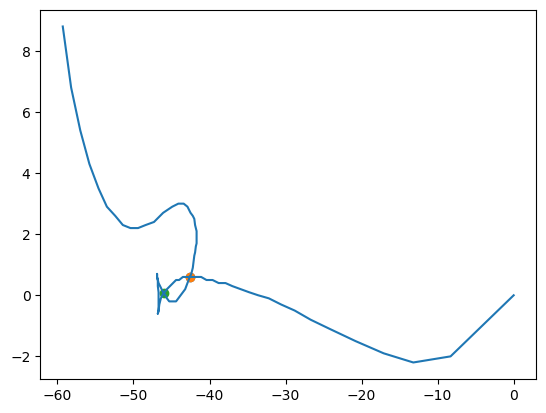

In [380]:
#DONE: verify the good looking crossing duration makes sense
plt.plot(x, y)
for n,row in df_c.iterrows():
    xs=row['xs_unwrap']
    ys=row['ys_unwrap']
    plt.scatter(xs, ys)#, color='r')
plt.show()

In [30]:

#TODO: test routine on one task
#TODO: generate task_lst


(0,
 '/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_log/',
 200,
 200,
 True,
 True)

In [ ]:
# df=track_particle_annihilations_pbc_nearest_neighbors_simple(df,width=200,height=200,
#                 max_disp=30, #15-1000 appears to work
#                 max_dist=20, # appears to work
#                 min_num_obs=1,use_final_annihilation=True,printing=True)